In [306]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score, mean_squared_error
#import AllTogether as t
import seaborn as sns
%matplotlib inline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.metrics import classification_report
from sklearn.ensemble import RandomForestRegressor

In [308]:
calendar = pd.read_csv('calendar_clean.csv')

In [309]:
listings = pd.read_csv('listings_clean.csv')

In [312]:
print(calendar.columns)
print(listings.columns)

Index(['listing_id', 'date', 'available', 'price', 'season', 'occupied'], dtype='object')
Index(['id', 'host_is_superhost', 'neighbourhood_cleansed', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'amenities', 'price', 'guests_included', 'extra_people',
       'minimum_nights', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'reviews_per_month'],
      dtype='object')


In [314]:
listings.rename(columns={'id': 'listing_id'}, inplace=True)

In [316]:
# Revisar duplicados
print(calendar['listing_id'].duplicated().sum())
print(listings['listing_id'].duplicated().sum())

1305305
0


In [318]:
calendar_cleaned = calendar.drop_duplicates(subset=['listing_id', 'date'])

In [320]:
combined = calendar_cleaned.merge(listings, on='listing_id', how='inner')
combined.head()

,listing_id,date,available,price_x,season,occupied,host_is_superhost,neighbourhood_cleansed,property_type,room_type,...,bed_type,amenities,price_y,guests_included,extra_people,minimum_nights,availability_365,number_of_reviews,review_scores_rating,reviews_per_month
0,12147973,2017-09-05,0,190.804553,Fall,0,f,Roslindale,House,Entire home/apt,...,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",250.0,1,0.0,2,0,0,94.0,1.05
1,12147973,2017-09-04,0,189.907829,Fall,0,f,Roslindale,House,Entire home/apt,...,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",250.0,1,0.0,2,0,0,94.0,1.05
2,12147973,2017-09-03,0,192.566038,Fall,0,f,Roslindale,House,Entire home/apt,...,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",250.0,1,0.0,2,0,0,94.0,1.05
3,12147973,2017-09-02,0,197.997775,Fall,0,f,Roslindale,House,Entire home/apt,...,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",250.0,1,0.0,2,0,0,94.0,1.05
4,12147973,2017-09-01,0,202.046797,Fall,0,f,Roslindale,House,Entire home/apt,...,Real Bed,"{TV,""Wireless Internet"",Kitchen,""Free Parking ...",250.0,1,0.0,2,0,0,94.0,1.05


In [324]:
seasonal_data = combined.groupby('season').agg(
    total_occupancy=('occupied', 'sum'),
    average_price=('price_x', 'mean'),
    total_listings=('listing_id', 'nunique')
).reset_index()

print(seasonal_data)

   season  total_occupancy  average_price  total_listings
0    Fall                0     227.165803            3585
1  Spring                0     190.996871            3585
2  Summer                0     200.828003            3585
3  Winter                0     185.615484            3585


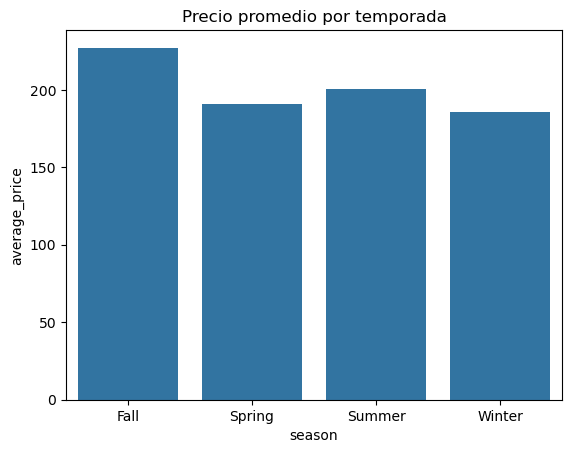

In [328]:
# Visualizamos el cambio de precio por temporada
sns.barplot(x='season', y='average_price', data=seasonal_data)
plt.title('Precio promedio por temporada')
plt.show()

#### Modelo de Disponibilidad

In [297]:
combined.columns

Index(['listing_id', 'date', 'available', 'price_x', 'season', 'occupied',
       'host_is_superhost', 'neighbourhood_cleansed', 'property_type',
       'room_type', 'accommodates', 'bathrooms', 'bedrooms', 'beds',
       'bed_type', 'amenities', 'price_y', 'guests_included', 'extra_people',
       'minimum_nights', 'availability_365', 'number_of_reviews',
       'review_scores_rating', 'reviews_per_month'],
      dtype='object')

In [299]:
# Convertir las variables categóricas en variables dummy (por ejemplo, 'season')
combined = pd.get_dummies(combined, columns=['season'], drop_first=True)

# Definir características (X) y objetivo (y)
X = combined[['price_x', 'accommodates', 'bathrooms', 'bedrooms', 'beds'] + [col for col in combined.columns if 'season_' in col]]
y_availability = combined['available']

# Dividir en datos de entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y_availability, test_size=0.2, random_state=42)

# Entrenar el modelo de clasificación
model_availability = RandomForestClassifier(n_estimators=100, random_state=42)
model_availability.fit(X_train, y_train)

# Hacer predicciones y evaluar el modelo
y_pred_availability = model_availability.predict(X_test)
print(classification_report(y_test, y_pred_availability))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00    133097
           1       1.00      1.00      1.00    128608

    accuracy                           1.00    261705
   macro avg       1.00      1.00      1.00    261705
weighted avg       1.00      1.00      1.00    261705



In [300]:
# Hacer predicciones en el conjunto de prueba
y_pred = model_availability.predict(X_test)

# Calcular el accuracy
accuracy = accuracy_score(y_test, y_pred)

# Imprimir el accuracy
print(f'Accuracy: {accuracy:.4f}, disponibilidad de los listados de Airbnb') 

Accuracy: 0.9992, disponibilidad de los listados de Airbnb


#### Modelo Price


In [333]:
# Definir características (X) y objetivo (y)
X = combined[['price_x', 'accommodates', 'bathrooms', 'bedrooms', 'beds'] + [col for col in combined.columns if 'season_' in col]]
y = combined['price_x']  # Variable objetivo es el precio

# Dividir los datos en entrenamiento y prueba
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Entrenar el modelo de regresión
model_price = RandomForestRegressor(n_estimators=100, random_state=42)
model_price.fit(X_train, y_train)

# Hacer predicciones
y_pred_price = model_price.predict(X_test)

# Evaluar el modelo
mse = mean_squared_error(y_test, y_pred_price)
print(f'Mean Squared Error: {mse}')

Mean Squared Error: 0.5787895240824592
